In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
parado=pd.read_csv("Data set 9 minutos parado.csv",dtype={0: str}, sep=';')
random=pd.read_csv("Data set 1000 movimientos random.csv",dtype={0: str}, sep=';')
home=pd.read_csv("Data set 50 movimientos home.csv",dtype={0: str}, sep=';')
#lectura de los ficheros csv. Usando ';' como separador y leyendo todos sus campos como string

In [3]:
parado.iloc[:, 0] = parado.iloc[:, 0].str.replace('.', ',').replace(';','  ')
random.iloc[:, 0] = random.iloc[:, 0].str.replace('.', ',').replace(';','  ')
home.iloc[:, 0] = home.iloc[:, 0].str.replace('.', ',').replace(';','  ')
#sustitución de los '.' por ',' y de ';' por '  ' para poder ser leídos correctamente como dataframes.

In [4]:
parado['Tipo'] = 'Parado'
random['Tipo'] = 'random'
home['Tipo'] = 'home'
#Añadimos una columna en cada dataset que indique a que tipo de movimiento pertenece

In [5]:
random

,A,B,C,D,Tipo
0,"0,43",44,32,1016,random
1,"0,155",41,24,1014,random
2,"0,164",41,24,1014,random
3,"0,166",41,24,1014,random
4,"0,166",39,26,1016,random
...,...,...,...,...,...
651953,"36,905",41,40,1014,random
651954,"36,908",41,40,1014,random
651955,"36,911",41,40,1014,random
651956,"36,914",41,40,1014,random


In [6]:
dataset = pd.concat([parado,home,random], axis=0)
#concatenamos los 3 datasets en uno

In [7]:
dataset.isnull().sum()
#Nos aseguramos de que no haya valores nulos porque no pueden ser procesados por la red neuronal

A       0
B       0
C       0
D       0
Tipo    0
dtype: int64

In [8]:
Fs = 20
activities = dataset['Tipo'].value_counts().index

In [9]:
activities

Index(['random', 'home', 'Parado'], dtype='object')

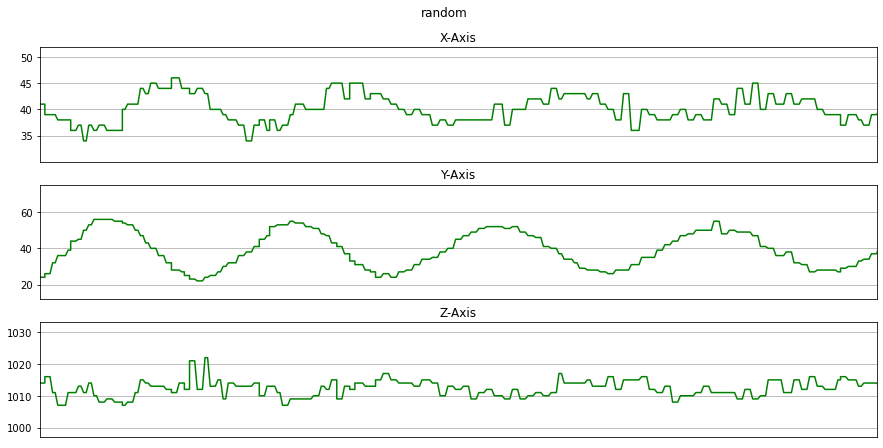

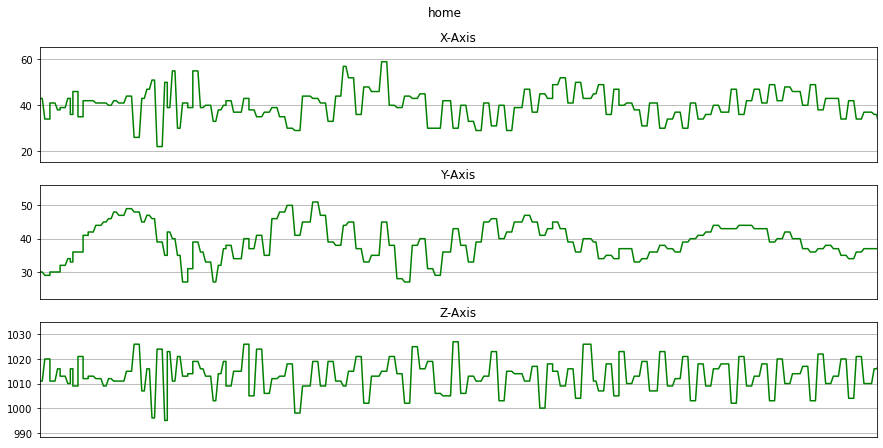

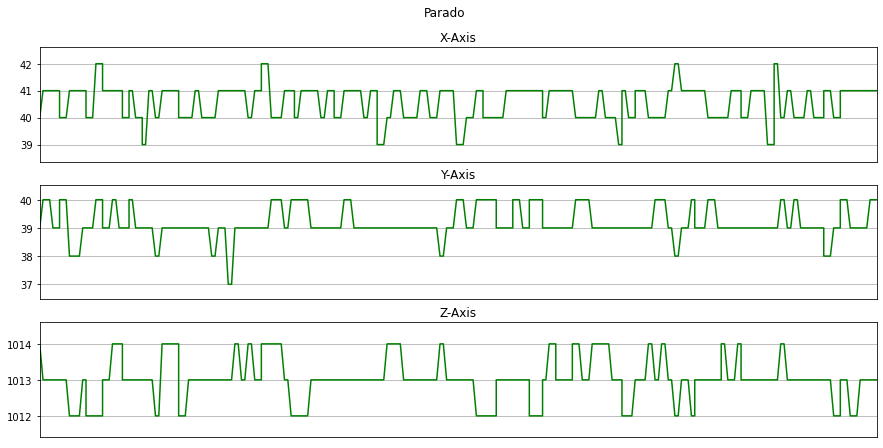

In [10]:
def plot_activity(activity, dataset):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, dataset['A'], dataset['B'], 'X-Axis')
    plot_axis(ax1, dataset['A'], dataset['C'], 'Y-Axis')
    plot_axis(ax2, dataset['A'], dataset['D'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = dataset[(dataset['Tipo'] == activity)][:Fs*20]
    plot_activity(activity, data_for_plot)
    
    
#Dibujamos una muestra de cada uno de los ejes de los tres datasets

In [11]:
dataset['Tipo'].value_counts()

random    651958
home      321013
Parado    164363
Name: Tipo, dtype: int64

In [12]:
Random = random.head(164363).copy()
Home = home.head(164363).copy()
Parado = parado.copy()

balanced_data  = pd.DataFrame()
balanced_data  = balanced_data .append([Random, Home, Parado])
balanced_data .shape

#Igualamos los tamaños de los 3 dataframes y los juntamos en 1

(493089, 5)

In [13]:
balanced_data.head()

,A,B,C,D,Tipo
0,"0,43",44,32,1016,random
1,"0,155",41,24,1014,random
2,"0,164",41,24,1014,random
3,"0,166",41,24,1014,random
4,"0,166",39,26,1016,random


In [14]:
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['Tipo'])
balanced_data.head()

#Generamos un label por cada tipo de movimiento

,A,B,C,D,Tipo,label
0,"0,43",44,32,1016,random,2
1,"0,155",41,24,1014,random,2
2,"0,164",41,24,1014,random,2
3,"0,166",41,24,1014,random,2
4,"0,166",39,26,1016,random,2


In [15]:
data = balanced_data.drop(['A'], axis = 1).copy()


data['D'] = balanced_data['D'].astype('float')
data['B'] = balanced_data['B'].astype('float')
data['C'] = balanced_data['C'].astype('float')

#Eliminamos la columna de referencia de tiempo y convertimos el tipo de dato de la columna en float

In [16]:
data = data.drop(['Tipo'], axis = 1).copy()
X = data[['D', 'B', 'C']]
y = data['label']

#Dividimos los datos por una parte (X) y los resultados por otro (y)

In [17]:
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [18]:
Fs = 20
frame_size = Fs*32 # Tamaño de frame
hop_size = Fs*2 # Tamaño de salto


In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['D', 'B', 'C'])
scaled_X['label'] = y.values

scaled_X.head()

,D,B,C,label
0,0.637077,1.137488,-1.156714,2
1,0.288259,0.219040,-2.442791,2
2,0.288259,0.219040,-2.442791,2
3,0.288259,0.219040,-2.442791,2
4,0.637077,-0.393259,-2.121272,2


In [20]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['D'].values[i: i + frame_size]
        y = df['B'].values[i: i + frame_size]
        z = df['C'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape
#Agrupamos los datos en frames

((12312, 640, 3), (12312,))

In [21]:
np.int = int #linea para que no de error 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape

((9849, 640, 3), (2463, 640, 3))

In [23]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
print(tf.__version__)

2.9.1


In [24]:
model = Sequential()

model.add(Conv1D(filters=8,kernel_size=3, activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv1D(filters=4,kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

#Definimos nuestro modelo de red neuronal

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493089 entries, 0 to 164362
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   B       493089 non-null  float64
 1   C       493089 non-null  float64
 2   D       493089 non-null  float64
 3   label   493089 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 16.9 MB


In [26]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 500, validation_data= (X_test, y_test), verbose=1)
#Entrenamos nuestro modelo de red neuronal

Epoch 1/500
308/308 [==============================] - 3s 7ms/step - loss: 0.3768 - accuracy: 0.8328 - val_loss: 0.1422 - val_accuracy: 0.9505
Epoch 2/500
308/308 [==============================] - 2s 7ms/step - loss: 0.1388 - accuracy: 0.9505 - val_loss: 0.0860 - val_accuracy: 0.9748
Epoch 3/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0956 - accuracy: 0.9657 - val_loss: 0.0502 - val_accuracy: 0.9834
Epoch 4/500
308/308 [==============================] - 2s 8ms/step - loss: 0.0688 - accuracy: 0.9769 - val_loss: 0.0422 - val_accuracy: 0.9870
Epoch 5/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0528 - accuracy: 0.9809 - val_loss: 0.0345 - val_accuracy: 0.9874
Epoch 6/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0424 - accuracy: 0.9848 - val_loss: 0.0290 - val_accuracy: 0.9886
Epoch 7/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0398 - accuracy: 0.9850 - val_loss: 0.0217 - val_accuracy: 0.9898

Epoch 58/500
308/308 [==============================] - 2s 5ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 0.0207 - val_accuracy: 0.9947
Epoch 59/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0267 - val_accuracy: 0.9923
Epoch 60/500
308/308 [==============================] - 2s 5ms/step - loss: 0.0131 - accuracy: 0.9957 - val_loss: 0.0248 - val_accuracy: 0.9943
Epoch 61/500
308/308 [==============================] - 2s 5ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0238 - val_accuracy: 0.9931
Epoch 62/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0088 - accuracy: 0.9963 - val_loss: 0.0194 - val_accuracy: 0.9943
Epoch 63/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.0244 - val_accuracy: 0.9947
Epoch 64/500
308/308 [==============================] - 2s 7ms/step - loss: 0.0135 - accuracy: 0.9961 - val_loss: 0.0244 - val_accuracy:

Epoch 115/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0085 - accuracy: 0.9972 - val_loss: 0.0153 - val_accuracy: 0.9955
Epoch 116/500
308/308 [==============================] - 2s 5ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.0166 - val_accuracy: 0.9955
Epoch 117/500
308/308 [==============================] - 2s 5ms/step - loss: 0.0097 - accuracy: 0.9965 - val_loss: 0.0180 - val_accuracy: 0.9959
Epoch 118/500
308/308 [==============================] - 2s 7ms/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.0336 - val_accuracy: 0.9919
Epoch 119/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.0200 - val_accuracy: 0.9943
Epoch 120/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0276 - val_accuracy: 0.9935
Epoch 121/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.0241 - val_ac

308/308 [==============================] - 2s 5ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0279 - val_accuracy: 0.9935
Epoch 228/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0048 - accuracy: 0.9982 - val_loss: 0.0293 - val_accuracy: 0.9939
Epoch 229/500
308/308 [==============================] - 2s 5ms/step - loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.0256 - val_accuracy: 0.9943
Epoch 230/500
308/308 [==============================] - 2s 5ms/step - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.0198 - val_accuracy: 0.9939
Epoch 231/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0249 - val_accuracy: 0.9943
Epoch 232/500
308/308 [==============================] - 2s 5ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0267 - val_accuracy: 0.9951
Epoch 233/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0267 - val_accuracy: 0.9935

308/308 [==============================] - 2s 6ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0203 - val_accuracy: 0.9963
Epoch 340/500
308/308 [==============================] - 2s 7ms/step - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0253 - val_accuracy: 0.9947
Epoch 341/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0149 - val_accuracy: 0.9976
Epoch 342/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0091 - accuracy: 0.9978 - val_loss: 0.0473 - val_accuracy: 0.9923
Epoch 343/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0183 - val_accuracy: 0.9959
Epoch 344/500
308/308 [==============================] - 2s 7ms/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.0137 - val_accuracy: 0.9955
Epoch 345/500
308/308 [==============================] - 4s 12ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0266 - val_accuracy: 0.995

308/308 [==============================] - 2s 5ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.0208 - val_accuracy: 0.9955
Epoch 452/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 0.0153 - val_accuracy: 0.9968
Epoch 453/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0083 - accuracy: 0.9987 - val_loss: 0.0102 - val_accuracy: 0.9980
Epoch 454/500
308/308 [==============================] - 2s 7ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0120 - val_accuracy: 0.9963
Epoch 455/500
308/308 [==============================] - 2s 5ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0149 - val_accuracy: 0.9951
Epoch 456/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 0.0195 - val_accuracy: 0.9951
Epoch 457/500
308/308 [==============================] - 2s 6ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0488 - val_accuracy: 0.9923

In [27]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

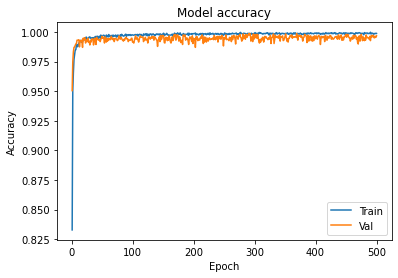

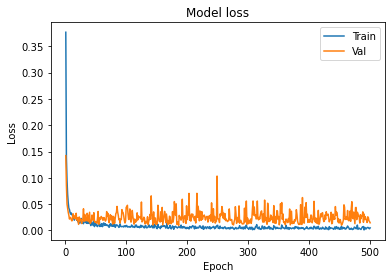

In [28]:
plot_learningCurve(history, 500)

#Mostramos la precisión y pérdida a lo largo del entrenamiento

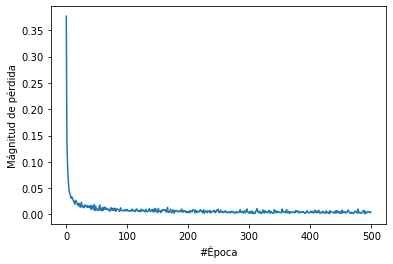

In [29]:
plt.xlabel('#Época')
plt.ylabel('Mágnitud de pérdida')
plt.plot(history.history['loss'])
plt.show()

In [30]:
model.save('red_neuronal_tfg.h5')

#Guardamos el modelo

In [31]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [32]:
y_pred_x = model.predict(X_test)
y_pred=np.argmax(y_pred_x,axis=1)

77/77 [==============================] - 0s 1ms/step


In [33]:
y_pred

array([0, 1, 2, ..., 1, 1, 0], dtype=int64)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

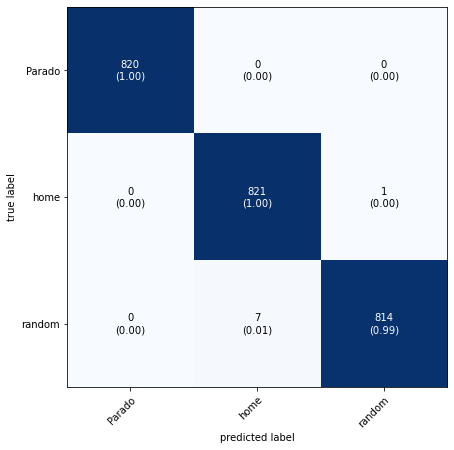

In [34]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))
#Generamos la matriz de confusión respecto a la predicción a los datos de test

In [35]:
model.evaluate(X_test,y_test)

77/77 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9968


[0.014609898440539837, 0.9967519044876099]

In [ ]:
#Aquí vamos a ver la precisión y la matriz de confusión para otro conjunto de datos diferente a los que hemos usado de entrenamiento.
#Para ello, repetiremos el proceso de preparación de los datos

In [36]:
parado=pd.read_csv("Data set estado reposo - 10 minutos.csv",dtype={0: str}, sep=';')
random=pd.read_csv("Data set movimientos random 2 - 1000 movimientos.csv",dtype={0: str}, sep=';')
home=pd.read_csv("Data set home 2 - 50  movimientos.csv",dtype={0: str}, sep=';')

In [37]:
parado.iloc[:, 0] = parado.iloc[:, 0].str.replace('.', ',').replace(';','  ')
random.iloc[:, 0] = random.iloc[:, 0].str.replace('.', ',').replace(';','  ')
home.iloc[:, 0] = home.iloc[:, 0].str.replace('.', ',').replace(';','  ')

In [38]:
parado['Tipo'] = 'Parado'
random['Tipo'] = 'random'
home['Tipo'] = 'home'

In [39]:
random

,A,B,C,D,Tipo
0,"0,0",39,37,1012,random
1,"0,30",39,37,1013,random
2,"0,105",40,37,1013,random
3,"0,106",40,37,1013,random
4,"0,107",40,37,1013,random
...,...,...,...,...,...
653502,"41,553",41,40,1012,random
653503,"41,556",41,40,1012,random
653504,"41,559",41,40,1012,random
653505,"41,562",41,40,1013,random


In [40]:
dataset = pd.concat([parado,home,random], axis=0)

In [41]:
dataset.isnull().sum()

A       0
B       0
C       0
D       0
Tipo    0
dtype: int64

In [42]:
Fs = 20
activities = dataset['Tipo'].value_counts().index

In [43]:
activities

Index(['random', 'home', 'Parado'], dtype='object')

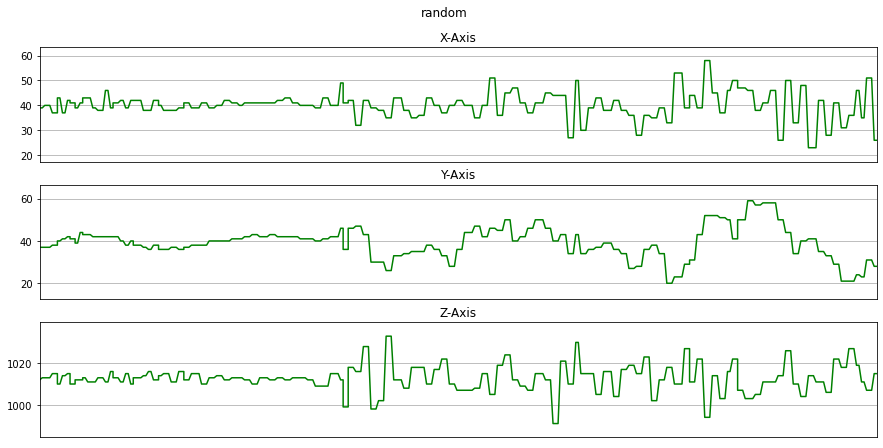

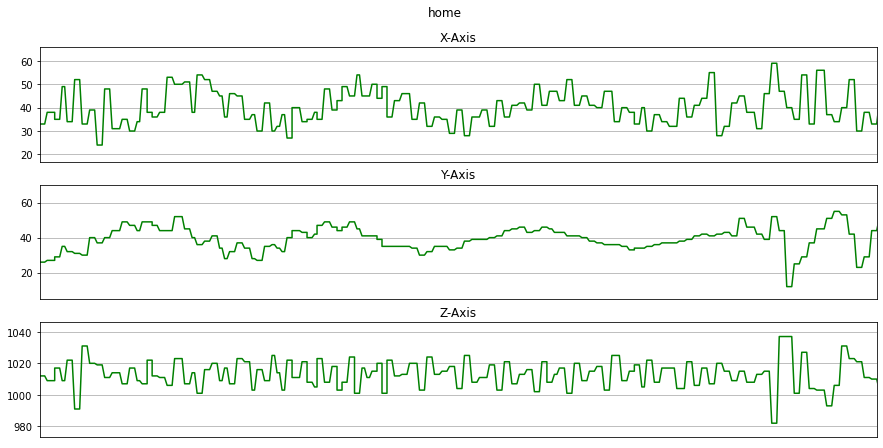

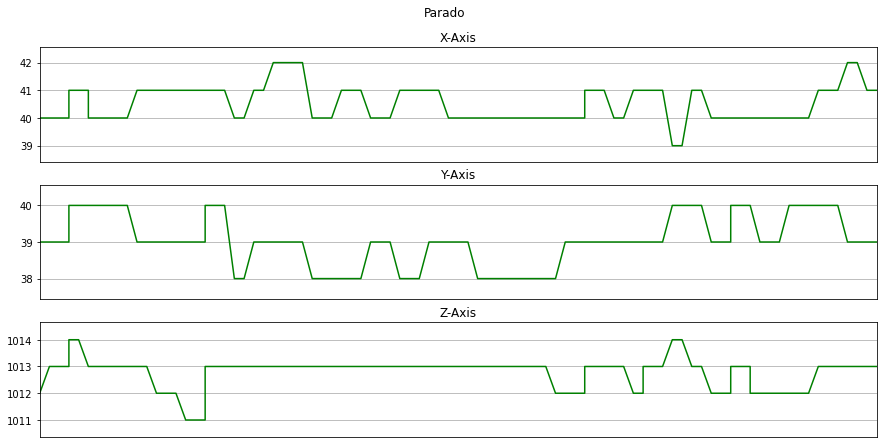

In [44]:
def plot_activity(activity, dataset):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, dataset['A'], dataset['B'], 'X-Axis')
    plot_axis(ax1, dataset['A'], dataset['C'], 'Y-Axis')
    plot_axis(ax2, dataset['A'], dataset['D'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = dataset[(dataset['Tipo'] == activity)][:Fs*20]
    plot_activity(activity, data_for_plot)

In [45]:
dataset['Tipo'].value_counts()

random    653507
home      316816
Parado    211572
Name: Tipo, dtype: int64

In [46]:
Random = random.head(164363).copy()
Home = home.head(164363).copy()
Parado = parado.copy()

balanced_data  = pd.DataFrame()
balanced_data  = balanced_data .append([Random, Home, Parado])
balanced_data .shape

(540298, 5)

In [47]:
balanced_data.head()

,A,B,C,D,Tipo
0,"0,0",39,37,1012,random
1,"0,30",39,37,1013,random
2,"0,105",40,37,1013,random
3,"0,106",40,37,1013,random
4,"0,107",40,37,1013,random


In [48]:
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['Tipo'])
balanced_data.head()

,A,B,C,D,Tipo,label
0,"0,0",39,37,1012,random,2
1,"0,30",39,37,1013,random,2
2,"0,105",40,37,1013,random,2
3,"0,106",40,37,1013,random,2
4,"0,107",40,37,1013,random,2


In [49]:
data = balanced_data.drop(['A'], axis = 1).copy()


data['D'] = balanced_data['D'].astype('float')
data['B'] = balanced_data['B'].astype('float')
data['C'] = balanced_data['C'].astype('float')

In [50]:
data = data.drop(['Tipo'], axis = 1).copy()
X = data[['D', 'B', 'C']]
y = data['label']



In [51]:
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [52]:
Fs = 20
frame_size = Fs*32 # 80
hop_size = Fs*2 # 40

In [53]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['D', 'B', 'C'])
scaled_X['label'] = y.values

scaled_X.head()

,D,B,C,label
0,-0.062269,-0.454221,-0.387628,2
1,0.113507,-0.454221,-0.387628,2
2,0.113507,-0.144483,-0.387628,2
3,0.113507,-0.144483,-0.387628,2
4,0.113507,-0.144483,-0.387628,2


In [54]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['D'].values[i: i + frame_size]
        y = df['B'].values[i: i + frame_size]
        z = df['C'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape

((13492, 640, 3), (13492,))

In [55]:
np.int = int #linea para que no de error 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape

((10793, 640, 3), (2699, 640, 3))

In [57]:
model.evaluate(X_train,y_train)

338/338 [==============================] - 0s 1ms/step - loss: 0.2315 - accuracy: 0.9867


[0.2315061390399933, 0.9866580367088318]

In [58]:
y_pred_x = model.predict(X_train)
y_pred=np.argmax(y_pred_x,axis=1)
prob_maximas = np.max(y_pred_x, axis=1)
predicciones_finales = np.where(prob_maximas < 0.9, 'desconocido', y_pred)
#Tomaremos como estado desconocido aquellas predicciones con menos de un 90% de probabilidad de acerdar.

338/338 [==============================] - 0s 1ms/step


In [59]:
print(y_pred[:10])

[2 1 2 0 0 0 2 1 2 1]


In [60]:
label.classes_

array(['Parado', 'home', 'random'], dtype=object)

In [61]:
np.sum(predicciones_finales == 'desconocido')
#Calculamos cuantas predicciones 'desconocidas' habría en nuestro dataset. Como se puede ver, no son muchos

61

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

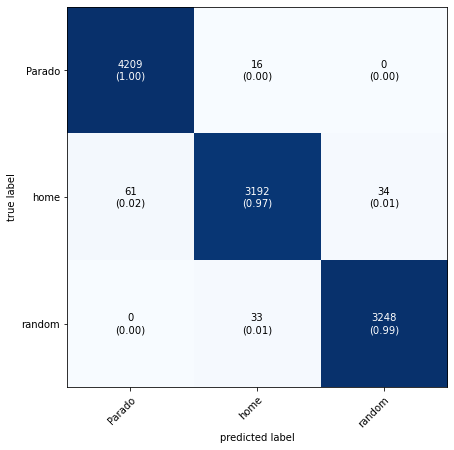

In [62]:

mat = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))
#Generamos la matriz de confusión

In [63]:
predicciones_finales

array(['2', '1', '2', ..., '2', '2', '0'], dtype='<U21')

In [64]:
np.set_printoptions(threshold=np.inf)
prob_maximas = np.max(y_pred_x, axis=1)
print(prob_maximas)
#Mostramos las probabilidades de las predicciones

[0.9999999  1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99984777 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99354607 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.9965209
 1.         1.         1.         1.         1.         1.
 1.         1.         0.98561263 1.         0.99970394 1.
 0.99999225 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.880134   1.         1.
 1.         1.         1.         0.9999951  1.  

In [65]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('modelo.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\usuario\AppData\Local\Temp\tmp7znucgj3\assets


INFO:tensorflow:Assets written to: C:\Users\usuario\AppData\Local\Temp\tmp7znucgj3\assets


In [76]:
num_classes = 3
y_one_hot = np.eye(num_classes)[y_train]

print(y_one_hot)
#Guardamos las soluciones a las predicciones como formato onehot

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1.

In [77]:
np.savez('mi_dataset.npz', input=X_train, output=y_one_hot)
#Guardamos el dataset como un archivo .npz